In [2]:

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
df = pd.read_csv('multivariate_eng_df.csv', parse_dates=['Date']).drop(columns=['Unnamed: 0'])
df.head()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


,Date,STATE,PROVINCE_STATE_NAME,Completeness_pct,Administered_Dose1_Recip,Administered_Dose1_Recip_5Plus,Administered_Dose1_Recip_12Plus,Administered_Dose1_Recip_18Plus,Administered_Dose1_Recip_65Plus,Series_Complete_Yes,...,vaccination_rate_complete,booster_rate,prop_age04,prop_age59,prop_age6064,prop_age8084,prop_age85plus,AGE04_29_TOT,AGE30_59_TOT,AGE60PLUS_TOT
0,2020-03-01,6,California,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.744418,6.165309,5.818187,1.71647,1.860398,13077768,15818572,8169914
1,2020-03-02,6,California,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.744418,6.165309,5.818187,1.71647,1.860398,13077768,15818572,8169914
2,2020-03-03,6,California,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.744418,6.165309,5.818187,1.71647,1.860398,13077768,15818572,8169914
3,2020-03-04,6,California,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.744418,6.165309,5.818187,1.71647,1.860398,13077768,15818572,8169914
4,2020-03-05,6,California,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,5.744418,6.165309,5.818187,1.71647,1.860398,13077768,15818572,8169914


In [3]:
#separate df for california -- multivariate still
ca_df = df.loc[df['PROVINCE_STATE_NAME'] == 'California']

#separate univariate dataframe for california
ca_uni_df = ca_df[['Date', 'PEOPLE_POSITIVE_NEW_CASES_COUNT']]
ca_uni_df = ca_uni_df.rename(columns={'Date': 'ds', 'PEOPLE_POSITIVE_NEW_CASES_COUNT': 'y'})


In [4]:
#separate train & test sets
train_size = int(len(ca_uni_df)* 0.8)
ca_uni_train, ca_uni_test = ca_uni_df[0:train_size], ca_uni_df[train_size:]

In [5]:
#use the default hyperparameters to initiate the Prophet model
model_baseline = Prophet()
#fit the model on the training dataset
model_baseline.fit(ca_uni_train)

02:46:59 - cmdstanpy - INFO - Chain [1] start processing
02:46:59 - cmdstanpy - INFO - Chain [1] done processing


In [6]:
print(len(ca_uni_test))

158


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


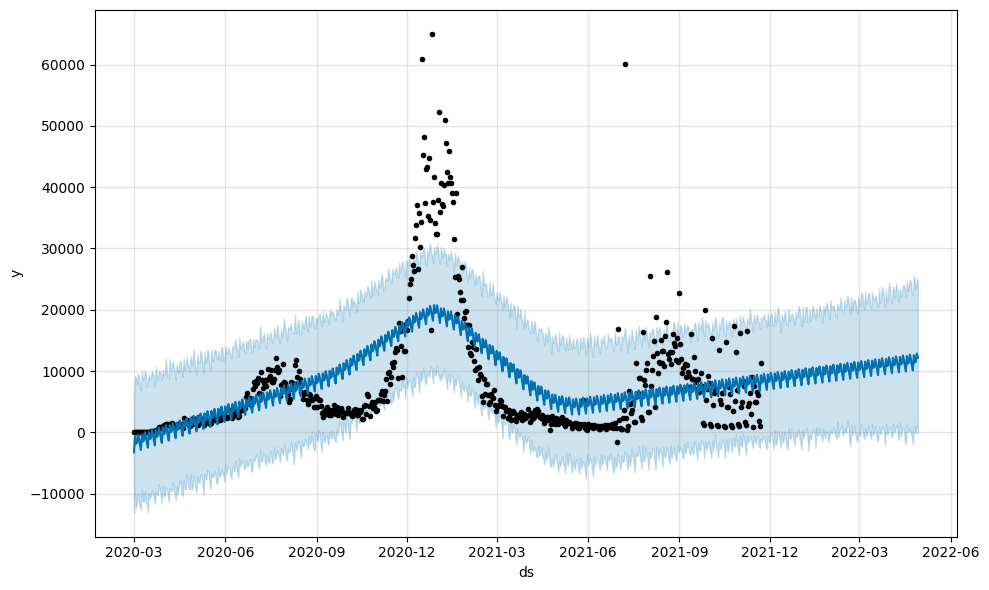

In [7]:
#create the time range for the forecast
future_baseline = model_baseline.make_future_dataframe(periods=158)
#make prediction
forecast_baseline = model_baseline.predict(future_baseline)
#visualize the forecast
model_baseline.plot(forecast_baseline); #add semi-colon to remove the duplicated chart

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()


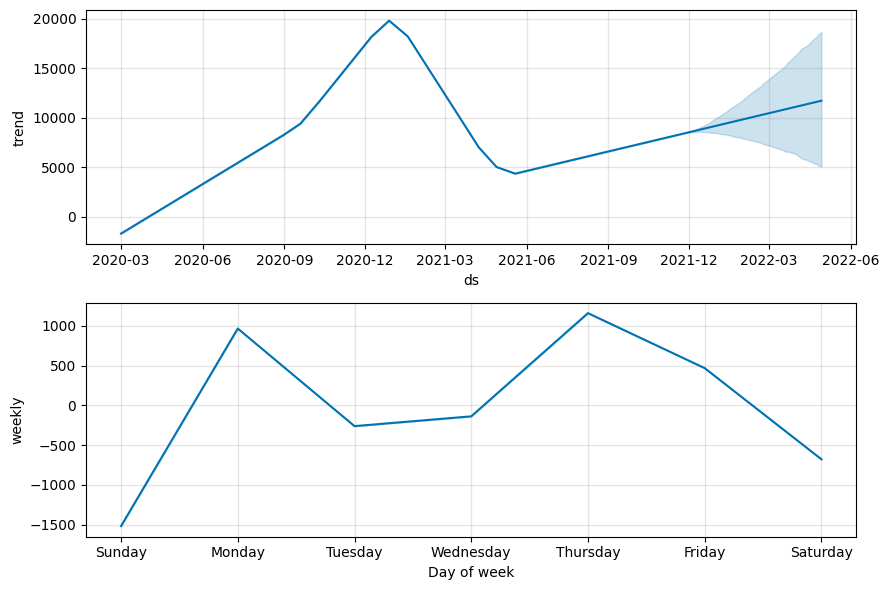

In [8]:
#visualize the forecast components
model_baseline.plot_components(forecast_baseline);

In [9]:
#merge actual and predicted values
performance_baseline = pd.merge(ca_uni_test, forecast_baseline[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-16:], on='ds')

#check MAE value
performance_baseline_MAE = mean_absolute_error(performance_baseline['y'], performance_baseline['yhat'])
print(f'The MAE for the baseline model is {performance_baseline_MAE}')

#check MAPE value
performance_baseline_MAPE = mean_absolute_percentage_error(performance_baseline['y'], performance_baseline['yhat'])
print(f'The MAPE for the baseline model is {performance_baseline_MAPE}')

The MAE for the baseline model is 7777.20759873564
The MAPE for the baseline model is 8.942225698866274e+18


In [10]:
#add seasonality into the model
#add seasonality
model_season = Prophet(yearly_seasonality=True, weekly_seasonality=True)
#fit the model on the training dataset
model_season.fit(ca_uni_train)

02:47:01 - cmdstanpy - INFO - Chain [1] start processing
02:47:01 - cmdstanpy - INFO - Chain [1] done processing


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


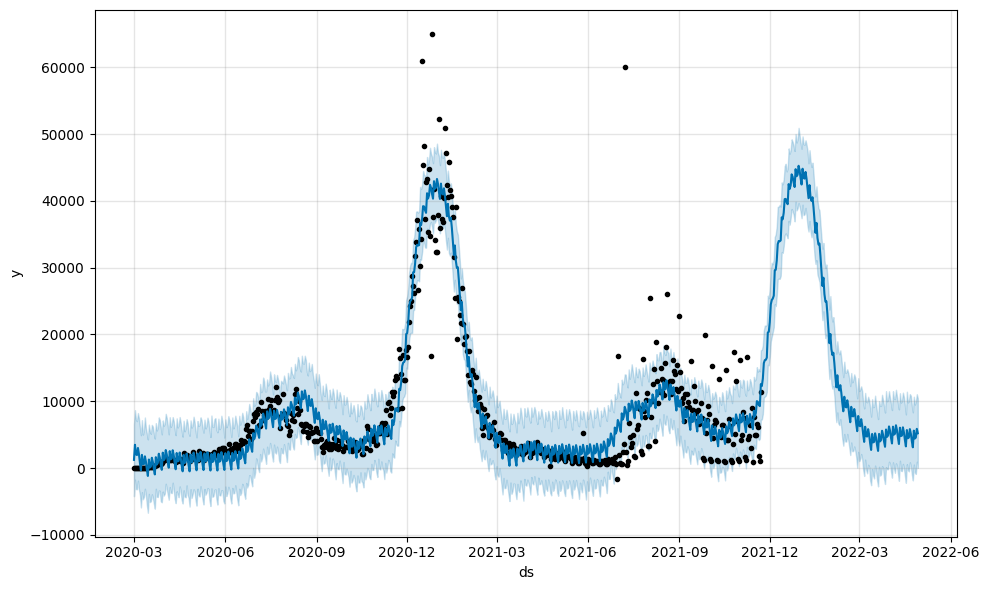

In [11]:
#create the time range for the forecast
future_season = model_season.make_future_dataframe(periods=158)

#make predictions
forecast_season = model_season.predict(future_season)
model_season.plot(forecast_season); # Add semi-colon to remove the duplicated chart

/var/folders/4b/sl3y8zds5g52xl7kl2dsn52w0000gn/T/ipykernel_864/2268752522.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ca_uni_test['ds'] = pd.to_datetime(ca_uni_test['ds'])


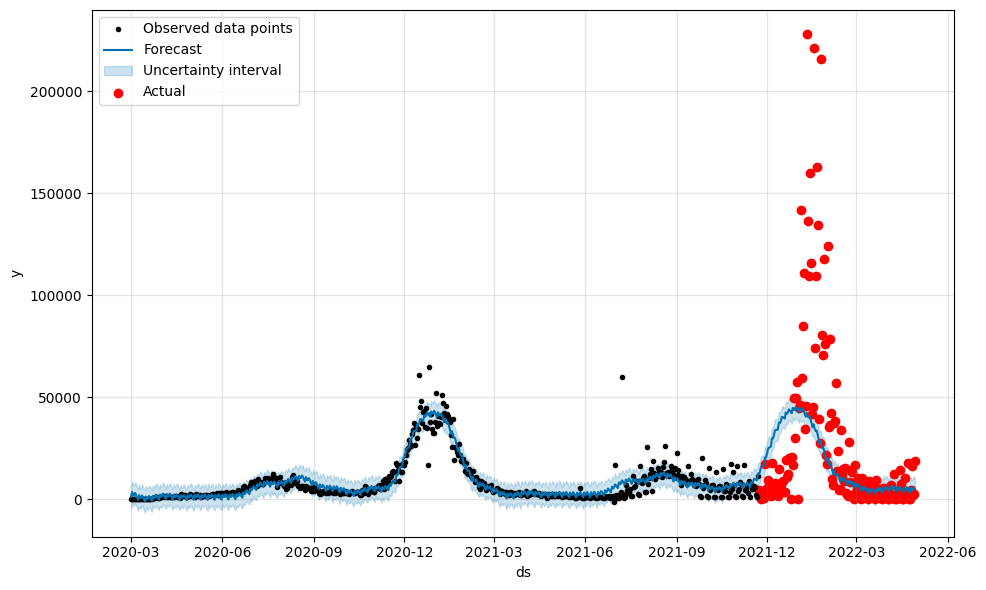

In [12]:
# Plot the forecast
fig = model_season.plot(forecast_season)

# Convert the 'Date' column to datetime if it's not already (adjust 'Date' if your column is named differently)
ca_uni_test['ds'] = pd.to_datetime(ca_uni_test['ds'])

# Plot the actual values on top of the forecast
# Assuming 'Date' is your datetime column and 'y' is the actual values column in ca_uni_test
plt.scatter(ca_uni_test['ds'], ca_uni_test['y'], color='red', label='Actual')

# Enhance the plot
plt.legend()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will retur

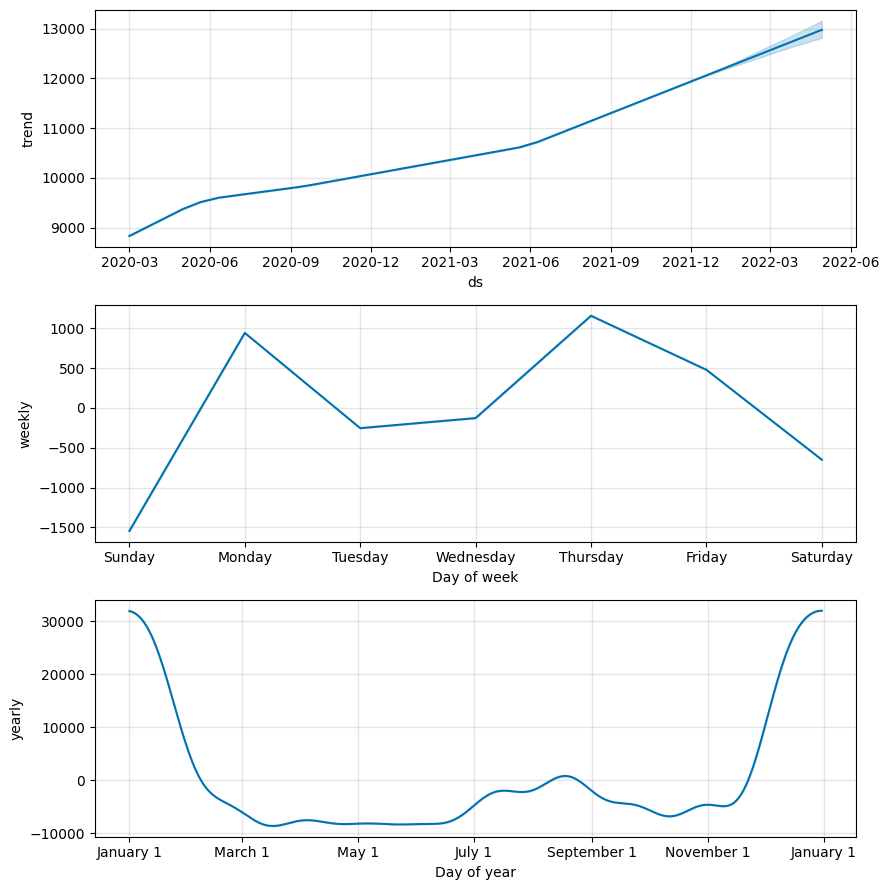

In [13]:
# Visualize the forecast components
model_season.plot_components(forecast_season);

In [14]:
# Merge actual and predicted values
performance_season = pd.merge(ca_uni_test, forecast_season[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-16:], on='ds')

# Check MAE value
performance_season_MAE = mean_absolute_error(performance_season['y'], performance_season['yhat'])
print(f'The MAE for the seasonality model is {performance_season_MAE}')

# Check MAPE value
performance_season_MAPE = mean_absolute_percentage_error(performance_season['y'], performance_season['yhat'])
print(f'The MAPE for the seasonality model is {performance_season_MAPE}')

The MAE for the seasonality model is 5326.526556134992
The MAPE for the seasonality model is 3.1827582555802317e+18


In [18]:
#naive forecast for mase calculation
naive_forecast = ca_uni_test['y'].shift(1)
#mae of the naive forecast (excluding first NaN value)
mae_naive = mean_absolute_error(ca_uni_test['y'][1:], naive_forecast.dropna())
mase = performance_season_MAE / mae_naive
print('Test MASE: ', mase)

Test MASE:  0.2705059899450179
